## Modelo de Detecção de Cachos

In [1]:
import random
import shutil
import uuid
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
import yaml
from ultralytics import YOLO
from PIL import Image

### Preparação dos Dados

In [2]:
# Download dos dados (repositório 1GB+)
# Posteriormente as imagens originais são removidas (1GB)

!git clone https://github.com/thsant/wgisd.git wgisd
!rm -rf wgisd/original_resolution

Cloning into 'wgisd'...
remote: Enumerating objects: 4267, done.
remote: Counting objects: 100% (867/867), done.
remote: Compressing objects: 100% (841/841), done.
remote: Total 4267 (delta 27), reused 859 (delta 24), pack-reused 3400
Receiving objects: 100% (4267/4267), 1.39 GiB | 34.43 MiB/s, done.
Resolving deltas: 100% (350/350), done.
Updating files: 100% (1853/1853), done.


Definição dos paths dos diretórios de trabalho.

In [2]:
source_data_dir = Path('wgisd/data')
clusters_dataset_dir = Path('datasets/clusters')
clusters_train_dir = clusters_dataset_dir/'train'
clusters_val_dir = clusters_dataset_dir/'val'
clusters_test_dir = clusters_dataset_dir/'test'

Criação da estrutura dos diretórios para os dados caso eles não existam.
- datasets/clusters/(train, test, val)/(images, labels)

In [3]:
(clusters_train_dir/'images').mkdir(parents=True, exist_ok=True)
(clusters_train_dir/'labels').mkdir(parents=True, exist_ok=True)

(clusters_val_dir/'images').mkdir(parents=True, exist_ok=True)
(clusters_val_dir/'labels').mkdir(parents=True, exist_ok=True)

(clusters_test_dir/'images').mkdir(parents=True, exist_ok=True)
(clusters_test_dir/'labels').mkdir(parents=True, exist_ok=True)

Separação das imagens em treinamento, validação e teste.
No próprio repositório dos dados existem arquivos de texto sugerindo uma separação para treino e teste.
Parte dos dados de treinamento são separados para a validação. Aqui é feita a separação dos nomes das imagens que vão para cada conjunto de dados.

In [3]:
with open('wgisd/train.txt', 'r') as file:
    train_imgs_names = file.read().rstrip().split('\n')
    
with open('wgisd/test.txt', 'r') as file:
    test_imgs_names = file.read().rstrip().split('\n')

val_size = int(len(train_imgs_names) * 0.2)
random.seed(42)
val_imgs_names = random.sample(train_imgs_names, val_size)

train_imgs_names = list(set(train_imgs_names) - set(val_imgs_names))

print('Número de imagens:')
print(f'Total: {len(train_imgs_names)+len(val_imgs_names)+len(test_imgs_names)}')
print(f'Treinamento: {len(train_imgs_names)}')
print(f'Validação: {len(val_imgs_names)}')
print(f'Teste: {len(test_imgs_names)}')

Número de imagens:
Total: 300
Treinamento: 194
Validação: 48
Teste: 58


Dados de treinamento, validação e teste são copiados para seus respectivos diretórios.

In [5]:
def copyToImagesLabelsDirsClusters(imgs_names: list, dst_dir: Path) -> None:

    for image_name in imgs_names:
        
        image_src_dir = source_data_dir/f'{image_name}.jpg'
        image_dst_dir = dst_dir/'images'/f'{image_name}.jpg'
    
        label_src_dir = source_data_dir/f'{image_name}.txt'
        label_dst_dir = dst_dir/'labels'/f'{image_name}.txt'
    
        shutil.copyfile(image_src_dir, image_dst_dir)
        shutil.copyfile(label_src_dir, label_dst_dir)

copyToImagesLabelsDirsClusters(train_imgs_names, clusters_train_dir)
copyToImagesLabelsDirsClusters(val_imgs_names, clusters_val_dir)
copyToImagesLabelsDirsClusters(test_imgs_names, clusters_test_dir)

Função para inserir os *bounding boxes* em uma imagem.

In [4]:
# Boxes representados em um arquivo texto no formato (classe x y w h) normalizado pelas dimensões da imagem.

def joinImageAndBoxes(img_path: Path|str, boxes_path: Path|str, thickness: int = 3) -> Image:
    
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    boxes_data = np.loadtxt(boxes_path)

    img_width = img.shape[1]
    img_height = img.shape[0]

    boxes_data[:, 1] = boxes_data[:, 1] * img_width
    boxes_data[:, 2] = boxes_data[:, 2] * img_height
    boxes_data[:, 3] = boxes_data[:, 3] * img_width
    boxes_data[:, 4] = boxes_data[:, 4] * img_height
    
    for box in boxes_data:

        x, y, w, h = box[1], box[2], box[3], box[4]

        x0 = x - w / 2
        x1 = x + w / 2
        y0 = y - h / 2
        y1 = y + h / 2

        start_point = (int(x0), int(y0))
        end_point = (int(x1), int(y1))

        cv2.rectangle(img, start_point, end_point, color=(255,0,0), thickness=thickness)

    return Image.fromarray(img)
    

Visualização de algumas imagens e labels de treinamento.

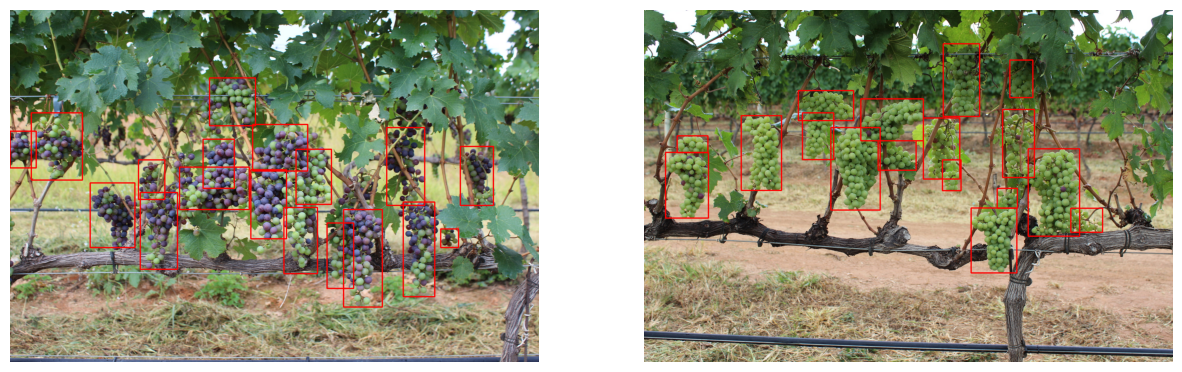

In [23]:
img_names = random.sample(train_imgs_names, 2)

image_1 = joinImageAndBoxes(source_data_dir/f'{img_names[0]}.jpg', source_data_dir/f'{img_names[0]}.txt', thickness=4)
image_2 = joinImageAndBoxes(source_data_dir/f'{img_names[1]}.jpg', source_data_dir/f'{img_names[1]}.txt', thickness=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_axis_off()
ax2.set_axis_off()
ax1.imshow(image_1)
ax2.imshow(image_2)
plt.show()

Arquivo de configuração dos dados para treinamento.

In [46]:
data_info = {'path': 'clusters',
             'train': 'train',
             'val': 'val',
             'test': 'test',
             'names': {'0': 'cluster'}}

with open('clusters_data.yaml', 'w') as file:
    yaml.safe_dump(data_info, file)

### Treinamento do Modelo

Modelo será treinado a partir de um modelo pré-treinado no dataset COCO.

In [9]:
pre_trained_model_path = Path('yolov8n.pt')
cluster_detection_model = YOLO(pre_trained_model_path)

data_config_path = Path('clusters_data.yaml')
project_name = 'cluster_detection'
model_name = 'v8n2'

results = cluster_detection_model.train(data=data_config_path,
                                      project=project_name,
                                      name=model_name,
                                      epochs=200,
                                      imgsz=1024,
                                      patience=200,
                                      batch=16,
                                      pretrained=True,
                                      seed=0,
                                      single_cls=True,
                                      plots=True)

New https://pypi.org/project/ultralytics/8.1.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=clusters_data.yaml, epochs=200, time=None, patience=200, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=cluster_detection, name=v8n2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

train: Scanning /home/leandro/projects/iot/yield_estimation/datasets/clusters/train/labels.cache... 194 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19
val: Scanning /home/leandro/projects/iot/yield_estimation/datasets/clusters/val/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [


Plotting labels to cluster_detection/v8n2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to cluster_detection/v8n2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      6.04G      1.834      2.958      1.679         50       1024: 100%|██████████| 13/13 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


                   all         58        850      0.864      0.269      0.568      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      6.47G      1.457      1.592      1.312         55       1024: 100%|██████████| 13/13 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.85it/s]

                   all         58        850      0.854      0.382        0.6      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200       6.2G      1.387      1.443      1.281         24       1024: 100%|██████████| 13/13 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]

                   all         58        850       0.82      0.423      0.646      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      6.33G       1.36      1.376      1.265         81       1024: 100%|██████████| 13/13 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]

                   all         58        850      0.636      0.509       0.54      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      6.47G      1.329      1.307      1.244         38       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]

                   all         58        850      0.695      0.587      0.643      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      6.96G      1.299      1.265      1.224         32       1024: 100%|██████████| 13/13 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]

                   all         58        850      0.749      0.622      0.704      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      7.37G      1.274      1.248      1.216         63       1024: 100%|██████████| 13/13 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]

                   all         58        850      0.797      0.695       0.78      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.24G      1.307      1.246      1.244         24       1024: 100%|██████████| 13/13 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]

                   all         58        850      0.734      0.673      0.745      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.15G      1.325      1.258      1.274         31       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]

                   all         58        850      0.724       0.72      0.778      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      6.04G      1.298      1.181       1.24         42       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.51it/s]

                   all         58        850      0.771      0.738      0.807      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.52G       1.27      1.142      1.217         26       1024: 100%|██████████| 13/13 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.84it/s]

                   all         58        850      0.779      0.685      0.778      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      6.42G      1.257      1.095      1.219         45       1024: 100%|██████████| 13/13 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]

                   all         58        850      0.747      0.658      0.733      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      5.97G      1.215      1.042      1.185         45       1024: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

                   all         58        850      0.839      0.701       0.82      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      6.92G      1.214      1.031      1.193         49       1024: 100%|██████████| 13/13 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.96it/s]

                   all         58        850      0.749      0.714      0.785      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      6.37G      1.208      1.065      1.176         17       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.94it/s]

                   all         58        850      0.741       0.64       0.72      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.11G      1.222      1.011      1.183         65       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.74it/s]

                   all         58        850      0.806      0.672      0.792      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      5.87G      1.181     0.9952      1.165         53       1024: 100%|██████████| 13/13 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.73it/s]

                   all         58        850      0.734      0.687      0.765      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      5.88G      1.193     0.9713      1.192         42       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.56it/s]

                   all         58        850      0.758      0.696      0.778      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      6.21G      1.196     0.9859      1.182         79       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.16it/s]

                   all         58        850      0.798      0.779      0.849      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      6.55G      1.219     0.9805      1.192         23       1024: 100%|██████████| 13/13 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.85it/s]

                   all         58        850      0.808      0.748      0.841      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      6.65G      1.168     0.9401       1.17         51       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.71it/s]

                   all         58        850      0.814       0.78      0.855      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      6.07G      1.146      0.935      1.154         40       1024: 100%|██████████| 13/13 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.24it/s]

                   all         58        850      0.844      0.755      0.863      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200         6G      1.137     0.8896      1.146         43       1024: 100%|██████████| 13/13 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.65it/s]

                   all         58        850      0.836      0.788       0.87      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200       6.8G      1.102     0.8883      1.148         27       1024: 100%|██████████| 13/13 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.94it/s]

                   all         58        850      0.837      0.804       0.88      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      6.23G      1.139     0.8955      1.161         39       1024: 100%|██████████| 13/13 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]

                   all         58        850      0.768      0.749      0.822      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      6.55G       1.17     0.9199      1.164         40       1024: 100%|██████████| 13/13 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.55it/s]

                   all         58        850      0.829      0.772      0.856      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      6.23G      1.157     0.8876      1.169         66       1024: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.46it/s]

                   all         58        850      0.811      0.768      0.854      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      6.54G       1.12     0.8661      1.147         46       1024: 100%|██████████| 13/13 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.93it/s]

                   all         58        850      0.829      0.708      0.834      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      5.92G      1.125     0.8675      1.134         53       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.18it/s]

                   all         58        850      0.799      0.772      0.844       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      5.81G      1.123      0.856      1.137         64       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.95it/s]

                   all         58        850      0.807      0.792      0.862      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      6.39G      1.107     0.8206      1.109         56       1024: 100%|██████████| 13/13 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.58it/s]

                   all         58        850      0.809      0.768      0.855      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      6.51G       1.08     0.8026       1.13         33       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.19it/s]

                   all         58        850       0.77       0.68      0.781      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      6.83G      1.101     0.8044      1.123         66       1024: 100%|██████████| 13/13 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.04it/s]

                   all         58        850      0.813      0.773      0.848      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      6.43G       1.06     0.7705      1.102         38       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.69it/s]

                   all         58        850      0.784        0.8      0.849      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      7.17G      1.097     0.7869      1.123         81       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.59it/s]

                   all         58        850      0.833      0.722      0.835      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      6.03G      1.097     0.7945      1.107         93       1024: 100%|██████████| 13/13 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.31it/s]

                   all         58        850      0.824      0.747      0.841      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.28G       1.09      0.778      1.129         76       1024: 100%|██████████| 13/13 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.22it/s]

                   all         58        850      0.766      0.796       0.85      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       6.4G      1.079     0.7554      1.112         57       1024: 100%|██████████| 13/13 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.42it/s]

                   all         58        850      0.822      0.814      0.874      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      6.48G      1.078     0.7565      1.114         44       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.69it/s]

                   all         58        850      0.816      0.769      0.835      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      6.41G      1.076      0.784      1.112         56       1024: 100%|██████████| 13/13 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.51it/s]

                   all         58        850      0.822      0.739      0.838       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.73G      1.106     0.8108      1.128         57       1024: 100%|██████████| 13/13 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.00it/s]

                   all         58        850      0.835       0.74      0.845      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      6.04G      1.063     0.7685      1.108         58       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]

                   all         58        850      0.823      0.728      0.839      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.35G      1.092       0.77      1.103         56       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.33it/s]

                   all         58        850      0.826      0.788      0.871      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      6.06G      1.054     0.7323      1.084         20       1024: 100%|██████████| 13/13 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.49it/s]

                   all         58        850      0.869      0.785      0.885      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200       6.4G      1.041     0.7198      1.086         90       1024: 100%|██████████| 13/13 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.45it/s]

                   all         58        850      0.839       0.81      0.882       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      5.93G      1.015     0.7085      1.073         52       1024: 100%|██████████| 13/13 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.20it/s]

                   all         58        850      0.845      0.798       0.88      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      6.25G      1.017     0.6996      1.076         56       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.33it/s]

                   all         58        850      0.881      0.774      0.879      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.22G      1.055     0.7307        1.1         41       1024: 100%|██████████| 13/13 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.45it/s]

                   all         58        850      0.844      0.777      0.867      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.53G      1.039     0.7175      1.098         37       1024: 100%|██████████| 13/13 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.76it/s]

                   all         58        850      0.791      0.769      0.843      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       6.2G      1.031     0.6832       1.08         33       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.32it/s]

                   all         58        850      0.821      0.778      0.862      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      6.41G      1.003      0.674      1.078         46       1024: 100%|██████████| 13/13 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.33it/s]

                   all         58        850      0.857      0.764      0.876      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      6.08G       1.03      0.687      1.078         64       1024: 100%|██████████| 13/13 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.95it/s]

                   all         58        850      0.854      0.771      0.857      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      6.57G      1.017     0.6781      1.077         68       1024: 100%|██████████| 13/13 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.69it/s]

                   all         58        850      0.816      0.805      0.858      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      6.48G      1.018     0.6654      1.075         55       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.29it/s]

                   all         58        850       0.82      0.807      0.871      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      6.17G      1.002       0.66      1.066         65       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.82it/s]

                   all         58        850      0.807      0.794      0.856      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      6.37G     0.9848     0.6893      1.061         15       1024: 100%|██████████| 13/13 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.00it/s]

                   all         58        850      0.801      0.739      0.817      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      6.13G      1.015     0.6576      1.062         38       1024: 100%|██████████| 13/13 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.82it/s]

                   all         58        850      0.841      0.781      0.863      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      6.11G     0.9987     0.6368      1.068         33       1024: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

                   all         58        850      0.853      0.787      0.877      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      6.43G     0.9862     0.6341      1.052         60       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.06it/s]

                   all         58        850      0.851      0.775      0.864      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      6.28G     0.9802     0.6575      1.063         30       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.10it/s]

                   all         58        850       0.85      0.778      0.856      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      5.95G     0.9693     0.6275      1.055         81       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.22it/s]

                   all         58        850      0.878      0.743      0.855      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       6.5G      0.992     0.6414      1.055         31       1024: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.32it/s]

                   all         58        850       0.84      0.759      0.851      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      6.04G     0.9736     0.6356      1.051         45       1024: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.16it/s]

                   all         58        850      0.828       0.78      0.855      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      6.18G     0.9778     0.6293      1.056         66       1024: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.71it/s]

                   all         58        850      0.809       0.79      0.857      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      6.03G      0.962      0.619      1.047         33       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.79it/s]

                   all         58        850      0.818      0.781      0.866      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      6.17G     0.9613     0.6214      1.038         59       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.89it/s]

                   all         58        850      0.856      0.798      0.883      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       6.7G     0.9555     0.6203      1.054         46       1024: 100%|██████████| 13/13 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.76it/s]

                   all         58        850      0.834      0.794      0.875      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      6.46G      0.955     0.6093      1.045         62       1024: 100%|██████████| 13/13 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.94it/s]

                   all         58        850      0.845      0.818      0.889      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      6.54G     0.9641     0.5971      1.041         52       1024: 100%|██████████| 13/13 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.17it/s]

                   all         58        850      0.824      0.806       0.87       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      6.39G     0.9824     0.6193      1.046        104       1024: 100%|██████████| 13/13 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

                   all         58        850      0.842      0.779      0.865      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      6.18G     0.9356     0.6009      1.047         48       1024: 100%|██████████| 13/13 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.01it/s]

                   all         58        850      0.816      0.788      0.867      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      6.51G     0.9532     0.6302       1.04         29       1024: 100%|██████████| 13/13 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.63it/s]

                   all         58        850       0.82      0.769      0.859      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200         6G     0.9418     0.6033      1.034         48       1024: 100%|██████████| 13/13 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.00it/s]

                   all         58        850      0.822      0.798      0.856       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      6.85G     0.9605     0.6055       1.04         71       1024: 100%|██████████| 13/13 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.01it/s]

                   all         58        850      0.835      0.788      0.862      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      6.05G     0.9383     0.5957      1.034         29       1024: 100%|██████████| 13/13 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.99it/s]

                   all         58        850      0.865      0.722       0.84      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.37G     0.9675      0.624      1.062         20       1024: 100%|██████████| 13/13 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.12it/s]

                   all         58        850      0.847      0.761      0.846      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      6.23G     0.8975     0.5547       1.02         36       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.15it/s]

                   all         58        850      0.807      0.834      0.871      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      6.52G     0.9499     0.5836       1.05         25       1024: 100%|██████████| 13/13 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.77it/s]

                   all         58        850      0.872      0.759      0.878       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      6.14G     0.8802     0.5546      1.019         60       1024: 100%|██████████| 13/13 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.07it/s]

                   all         58        850      0.844      0.779      0.872       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200       5.9G     0.9224      0.566      1.028         34       1024: 100%|██████████| 13/13 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

                   all         58        850      0.841      0.791       0.87      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      6.92G     0.9249     0.5661      1.027         30       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.07it/s]

                   all         58        850      0.836      0.789      0.866      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      6.58G     0.9185     0.5823      1.023         15       1024: 100%|██████████| 13/13 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.21it/s]

                   all         58        850      0.881      0.765      0.867      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      7.07G       0.94     0.5866      1.034         75       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.15it/s]

                   all         58        850      0.853      0.778       0.86      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      6.61G     0.9279     0.5862      1.026         53       1024: 100%|██████████| 13/13 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.06it/s]

                   all         58        850       0.87      0.788      0.862      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      6.16G      0.882     0.5372      1.016         45       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.84it/s]

                   all         58        850       0.87      0.765      0.863      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      6.49G     0.8856     0.5497      1.009         88       1024: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.84it/s]

                   all         58        850      0.828      0.804      0.863      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      6.59G     0.8863      0.553      1.021         20       1024: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.99it/s]

                   all         58        850       0.83      0.785      0.853      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      5.83G     0.9304     0.5837      1.043         16       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.18it/s]

                   all         58        850      0.815      0.806      0.866      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      6.57G     0.8944     0.5497      1.015         45       1024: 100%|██████████| 13/13 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.08it/s]

                   all         58        850      0.854      0.768      0.865      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      7.17G     0.9041     0.5407      1.012         61       1024: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.90it/s]

                   all         58        850      0.861      0.776      0.856      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      6.94G     0.8918     0.5412      1.005         57       1024: 100%|██████████| 13/13 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.20it/s]

                   all         58        850      0.856      0.762      0.856       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      6.64G     0.8562      0.519      1.003         21       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.25it/s]

                   all         58        850       0.86      0.766       0.86      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      6.11G     0.8622     0.5201     0.9896         43       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.18it/s]

                   all         58        850      0.844      0.782      0.857      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       5.8G      0.881     0.5347      1.012         32       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.96it/s]

                   all         58        850      0.855      0.789      0.864      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      6.54G     0.8557     0.5162      0.994         54       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.26it/s]

                   all         58        850      0.889      0.764       0.87       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      6.08G     0.8976     0.5312      1.007         54       1024: 100%|██████████| 13/13 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.01it/s]

                   all         58        850      0.872      0.786       0.86      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.77G      0.882     0.5193     0.9972         55       1024: 100%|██████████| 13/13 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.97it/s]

                   all         58        850      0.884      0.789      0.864      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      6.59G     0.9094     0.5362      1.009         96       1024: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.18it/s]

                   all         58        850      0.832      0.779      0.846      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      6.16G     0.8752     0.5154     0.9947         68       1024: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.15it/s]

                   all         58        850      0.837      0.796      0.871      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      7.02G     0.9057     0.5322      1.008         51       1024: 100%|██████████| 13/13 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.27it/s]

                   all         58        850      0.834      0.771      0.844      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      5.95G     0.8864     0.5273      1.006         49       1024: 100%|██████████| 13/13 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.79it/s]

                   all         58        850      0.858      0.769      0.864      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       5.9G     0.8724     0.5133      1.005         50       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.19it/s]

                   all         58        850      0.851      0.809      0.873      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      6.39G      0.837     0.4985     0.9997         22       1024: 100%|██████████| 13/13 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.04it/s]

                   all         58        850       0.87      0.789       0.87      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      6.42G     0.8502     0.5089     0.9901         78       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.87it/s]

                   all         58        850      0.869      0.736      0.835      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      6.13G     0.8402     0.4927     0.9831         38       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.27it/s]

                   all         58        850      0.836      0.807      0.875      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      7.15G     0.8303     0.4945     0.9812         47       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.31it/s]

                   all         58        850      0.816      0.789      0.854      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      6.36G     0.8779      0.518     0.9903         97       1024: 100%|██████████| 13/13 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.87it/s]

                   all         58        850      0.846      0.795      0.866      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      6.52G     0.8393     0.4962     0.9793         37       1024: 100%|██████████| 13/13 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.19it/s]

                   all         58        850      0.835      0.809       0.87      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      6.33G     0.8182     0.4826     0.9778         42       1024: 100%|██████████| 13/13 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.13it/s]

                   all         58        850      0.836       0.81      0.875      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      6.59G     0.8258      0.481     0.9778         40       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.05it/s]

                   all         58        850      0.838      0.803      0.874      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      6.77G     0.7999     0.4762      0.969         60       1024: 100%|██████████| 13/13 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.00it/s]

                   all         58        850      0.855      0.798      0.873      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      6.14G      0.822     0.4946     0.9802         69       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.29it/s]

                   all         58        850       0.86      0.794      0.869       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      6.47G      0.831     0.4919      0.982         27       1024: 100%|██████████| 13/13 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

                   all         58        850      0.846      0.799      0.864      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       6.4G     0.8131     0.4732     0.9815         14       1024: 100%|██████████| 13/13 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.25it/s]

                   all         58        850      0.871      0.779      0.869      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      6.46G     0.8206     0.4758     0.9835         34       1024: 100%|██████████| 13/13 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.25it/s]

                   all         58        850      0.849      0.808      0.878      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      6.36G     0.8056     0.4771     0.9678         65       1024: 100%|██████████| 13/13 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]

                   all         58        850      0.869      0.792      0.873      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200         6G     0.8192     0.4839     0.9822         39       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.44it/s]

                   all         58        850       0.83      0.815      0.872      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       6.3G     0.7888     0.4675     0.9759         22       1024: 100%|██████████| 13/13 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.90it/s]

                   all         58        850      0.877      0.773      0.877      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      6.95G     0.8138     0.4818     0.9654         81       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.23it/s]

                   all         58        850      0.884      0.783      0.886      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       6.3G     0.7913     0.4886     0.9671         20       1024: 100%|██████████| 13/13 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.17it/s]

                   all         58        850      0.864      0.807      0.877      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      6.51G     0.8472     0.4693     0.9839         42       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.01it/s]

                   all         58        850      0.892      0.791      0.871      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200       6.2G     0.8077     0.4636     0.9625         37       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.24it/s]

                   all         58        850      0.884      0.773      0.868      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      5.83G     0.7992     0.4626     0.9638         70       1024: 100%|██████████| 13/13 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.29it/s]

                   all         58        850      0.854      0.813      0.882      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      6.59G     0.8334     0.4907     0.9721        101       1024: 100%|██████████| 13/13 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.30it/s]

                   all         58        850      0.847      0.795      0.867      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      7.06G     0.8158     0.4727     0.9695         87       1024: 100%|██████████| 13/13 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.09it/s]

                   all         58        850      0.869      0.786      0.879      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      6.84G     0.7957     0.4607     0.9733         55       1024: 100%|██████████| 13/13 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.43it/s]

                   all         58        850      0.853      0.795      0.878      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      5.76G     0.7867     0.4433     0.9561         55       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.10it/s]

                   all         58        850      0.854       0.78      0.863      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      6.97G     0.7907     0.4551     0.9516         62       1024: 100%|██████████| 13/13 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.16it/s]

                   all         58        850      0.863      0.776      0.868      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      6.66G     0.7731     0.4496     0.9561         60       1024: 100%|██████████| 13/13 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.30it/s]

                   all         58        850       0.87      0.801      0.867      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      5.94G     0.7786     0.4459      0.953         36       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.29it/s]

                   all         58        850      0.869      0.796      0.877      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      6.06G     0.7871      0.453     0.9714         63       1024: 100%|██████████| 13/13 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.26it/s]

                   all         58        850       0.85      0.786       0.86      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      6.08G     0.7986     0.4576       0.96         74       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.28it/s]

                   all         58        850      0.857      0.785      0.873       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.99G     0.7821     0.4536     0.9561         80       1024: 100%|██████████| 13/13 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.10it/s]

                   all         58        850      0.818       0.82      0.878      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      5.77G     0.7835     0.4523       0.95         52       1024: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.35it/s]

                   all         58        850      0.845      0.803      0.871      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      6.51G     0.7847     0.4484     0.9634         34       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.29it/s]

                   all         58        850      0.853      0.816      0.877      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200       6.1G     0.7475     0.4275     0.9514         44       1024: 100%|██████████| 13/13 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.17it/s]

                   all         58        850      0.857      0.825       0.88      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      6.56G      0.787     0.4556     0.9721         43       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.18it/s]

                   all         58        850      0.845      0.822      0.876      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      6.39G     0.7716     0.4437     0.9456         93       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.25it/s]

                   all         58        850      0.868      0.791      0.877      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      5.82G     0.7569     0.4407     0.9381         84       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.52it/s]

                   all         58        850      0.856      0.801       0.87      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      6.19G     0.7556     0.4254     0.9386         65       1024: 100%|██████████| 13/13 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.39it/s]

                   all         58        850      0.882      0.778      0.875      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      6.64G      0.739     0.4221     0.9394         35       1024: 100%|██████████| 13/13 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.49it/s]

                   all         58        850      0.816      0.821      0.874      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      6.22G     0.7703     0.4414      0.959         30       1024: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.40it/s]

                   all         58        850      0.837      0.814      0.882       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200       6.3G     0.7543     0.4391     0.9494         29       1024: 100%|██████████| 13/13 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.34it/s]

                   all         58        850      0.838      0.807      0.874      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.91G     0.7417      0.435     0.9471         26       1024: 100%|██████████| 13/13 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.15it/s]

                   all         58        850      0.832      0.803      0.873      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200       6.4G     0.7641     0.4401     0.9479         33       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.13it/s]

                   all         58        850       0.85      0.782      0.864      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      6.46G     0.7243     0.4171     0.9388         56       1024: 100%|██████████| 13/13 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.14it/s]

                   all         58        850      0.863      0.792      0.867      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      6.49G     0.7419     0.4284     0.9396         50       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.44it/s]

                   all         58        850      0.868      0.779      0.862      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      6.28G     0.7254     0.4138     0.9276         40       1024: 100%|██████████| 13/13 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.41it/s]

                   all         58        850      0.843      0.803      0.867      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      6.23G     0.7306     0.4237     0.9483         32       1024: 100%|██████████| 13/13 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.38it/s]

                   all         58        850       0.88      0.775      0.874      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       6.6G     0.7367     0.4203     0.9445         32       1024: 100%|██████████| 13/13 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.23it/s]

                   all         58        850      0.862      0.776      0.856      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      6.49G     0.6934     0.4092     0.9355         23       1024: 100%|██████████| 13/13 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.37it/s]

                   all         58        850      0.845      0.804      0.866      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      6.17G     0.7312     0.4194     0.9343         46       1024: 100%|██████████| 13/13 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.33it/s]

                   all         58        850       0.87      0.771      0.865      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      7.02G     0.7005      0.411     0.9292         76       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]

                   all         58        850      0.872      0.771      0.853      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      6.26G     0.7129     0.4133     0.9399         52       1024: 100%|██████████| 13/13 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.26it/s]

                   all         58        850      0.851      0.786      0.865      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      6.87G     0.7232     0.4093     0.9341         44       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.94it/s]

                   all         58        850      0.872      0.803      0.883      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      6.31G     0.7364     0.4169     0.9285         81       1024: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.29it/s]

                   all         58        850      0.873      0.776      0.871      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      6.37G     0.7213     0.4135     0.9278         74       1024: 100%|██████████| 13/13 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.20it/s]

                   all         58        850      0.877        0.8      0.884      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      6.35G     0.7144     0.4098     0.9368         36       1024: 100%|██████████| 13/13 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.33it/s]

                   all         58        850      0.846      0.822      0.888      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      6.71G      0.719     0.4094     0.9231         64       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.17it/s]

                   all         58        850       0.88      0.794      0.884      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      6.93G      0.693      0.413     0.9303         28       1024: 100%|██████████| 13/13 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.59it/s]

                   all         58        850      0.871      0.782      0.868      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.84G     0.7128     0.4186     0.9369         74       1024: 100%|██████████| 13/13 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.34it/s]

                   all         58        850      0.869      0.782      0.865      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      6.47G     0.7016     0.4085     0.9355         20       1024: 100%|██████████| 13/13 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.44it/s]

                   all         58        850      0.868      0.781      0.858      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.92G     0.6939     0.4051     0.9321         78       1024: 100%|██████████| 13/13 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.57it/s]

                   all         58        850      0.877      0.764      0.859      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      6.91G     0.6965     0.4029     0.9274         50       1024: 100%|██████████| 13/13 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.27it/s]

                   all         58        850      0.862       0.78      0.862      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      6.49G     0.7175     0.4224     0.9415         35       1024: 100%|██████████| 13/13 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.36it/s]

                   all         58        850      0.859      0.779      0.862      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      6.51G     0.6835     0.3934     0.9192         41       1024: 100%|██████████| 13/13 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.38it/s]

                   all         58        850      0.842      0.801      0.869      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      6.09G        0.7     0.4012     0.9322         67       1024: 100%|██████████| 13/13 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.13it/s]

                   all         58        850      0.855      0.804      0.876      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.97G     0.6808     0.3904     0.9197         52       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.16it/s]

                   all         58        850       0.87      0.789      0.871      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      6.18G      0.648      0.378     0.9067         47       1024: 100%|██████████| 13/13 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.35it/s]

                   all         58        850       0.87      0.785      0.871      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      6.13G     0.6854     0.3945     0.9192         45       1024: 100%|██████████| 13/13 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.07it/s]

                   all         58        850      0.848      0.799      0.873      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      6.01G     0.6955     0.4108     0.9326         26       1024: 100%|██████████| 13/13 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.26it/s]

                   all         58        850      0.865      0.781      0.872       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.52G     0.6743     0.3929     0.9193         30       1024: 100%|██████████| 13/13 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.37it/s]

                   all         58        850      0.866      0.793      0.874      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      6.26G     0.7165     0.4147     0.9236         78       1024: 100%|██████████| 13/13 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.34it/s]

                   all         58        850      0.876      0.795      0.881       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      6.27G     0.6789     0.3863     0.9098         37       1024: 100%|██████████| 13/13 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.28it/s]

                   all         58        850      0.876        0.8      0.878      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      6.17G     0.6672     0.4049     0.9261         27       1024: 100%|██████████| 13/13 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.30it/s]

                   all         58        850      0.864      0.802      0.876      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      5.64G     0.6839     0.3899     0.9228         40       1024: 100%|██████████| 13/13 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.24it/s]

                   all         58        850      0.866      0.799      0.874      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      6.33G     0.6679     0.3839     0.9145         20       1024: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.41it/s]

                   all         58        850      0.866      0.796      0.879      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       6.4G     0.6632     0.3829      0.911         48       1024: 100%|██████████| 13/13 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.27it/s]

                   all         58        850       0.88      0.784      0.882      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.97G     0.6627     0.4016      0.927         26       1024: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.38it/s]

                   all         58        850      0.836      0.819       0.88      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      6.15G     0.6589     0.3786     0.9088         34       1024: 100%|██████████| 13/13 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.40it/s]

                   all         58        850      0.835      0.816      0.878      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.04G     0.6629     0.3811     0.9086         58       1024: 100%|██████████| 13/13 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]

                   all         58        850      0.904      0.755      0.876      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      6.47G      0.639     0.3683     0.9083         63       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.87it/s]

                   all         58        850      0.867       0.78      0.872      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      6.54G     0.6575     0.3809     0.9137         49       1024: 100%|██████████| 13/13 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.46it/s]

                   all         58        850      0.839      0.805      0.869      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      6.09G     0.6615     0.3777     0.9056         45       1024: 100%|██████████| 13/13 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.34it/s]

                   all         58        850      0.905      0.754      0.864      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200       6.9G     0.6508     0.3843     0.9174         24       1024: 100%|██████████| 13/13 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]

                   all         58        850      0.897      0.757      0.866      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      6.19G     0.6915     0.3985     0.9248         88       1024: 100%|██████████| 13/13 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.28it/s]

                   all         58        850      0.846      0.805      0.868      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      6.52G     0.6602     0.3811     0.9138         61       1024: 100%|██████████| 13/13 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.24it/s]

                   all         58        850      0.827      0.818      0.868      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      6.46G      0.631     0.3612     0.9097         37       1024: 100%|██████████| 13/13 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.34it/s]

                   all         58        850      0.856       0.79      0.862      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      6.12G     0.6638      0.382     0.9178         36       1024: 100%|██████████| 13/13 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.23it/s]

                   all         58        850      0.829      0.814      0.868      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      6.19G      0.667     0.3879     0.9173         44       1024: 100%|██████████| 13/13 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]

                   all         58        850      0.859      0.793      0.871      0.582


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      6.22G     0.6884     0.4153     0.9194         21       1024: 100%|██████████| 13/13 [00:01<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.21it/s]

                   all         58        850      0.866      0.794      0.868      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      5.71G     0.5932     0.3375     0.8856         34       1024: 100%|██████████| 13/13 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.15it/s]

                   all         58        850       0.87      0.774      0.855      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      5.71G     0.6107     0.3403     0.8824         26       1024: 100%|██████████| 13/13 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.44it/s]

                   all         58        850      0.859      0.784      0.856      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      5.48G      0.619     0.3558     0.8803         26       1024: 100%|██████████| 13/13 [00:00<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.29it/s]

                   all         58        850      0.856      0.792      0.864      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      5.72G     0.6279     0.3456     0.8942         33       1024: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.46it/s]

                   all         58        850      0.861        0.8      0.869       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      5.74G      0.579     0.3245     0.8721         27       1024: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.50it/s]

                   all         58        850      0.901      0.769      0.868       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      5.47G     0.5888     0.3286     0.8688         25       1024: 100%|██████████| 13/13 [00:00<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.53it/s]

                   all         58        850      0.859      0.804       0.87      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      5.71G     0.5834     0.3213     0.8683         28       1024: 100%|██████████| 13/13 [00:00<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.37it/s]

                   all         58        850      0.903      0.772      0.874      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       5.7G     0.5723     0.3129     0.8708         26       1024: 100%|██████████| 13/13 [00:00<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.47it/s]

                   all         58        850      0.906      0.771      0.874      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      5.47G     0.5865     0.3274     0.8742         41       1024: 100%|██████████| 13/13 [00:00<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.47it/s]

                   all         58        850      0.892      0.766      0.871      0.573



200 epochs completed in 0.071 hours.
Optimizer stripped from cluster_detection/v8n2/weights/last.pt, 6.3MB
Optimizer stripped from cluster_detection/v8n2/weights/best.pt, 6.3MB

Validating cluster_detection/v8n2/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]


                   all         58        850      0.846      0.824      0.888      0.592
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to cluster_detection/v8n2


Contagem dos cachos através do modelo treinado.

Validação do modelo com parâmetros de iou e conf ajustados de acordo com o melhor resultado na contagem dos cachos.

In [12]:
model = YOLO('cluster_detection/v8n2/weights/best.pt')

In [13]:
# Dados de teste foram utilizados aqui, apesar da função val.

val_metrics = model.val(conf=0.4, iou=0.5, plots=True)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/leandro/projects/iot/yield_estimation/datasets/clusters/val/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


                   all         58        850      0.867      0.825      0.876      0.616
Speed: 2.3ms preprocess, 5.8ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/val18


In [15]:
val_metrics.box.f1

array([    0.84521])

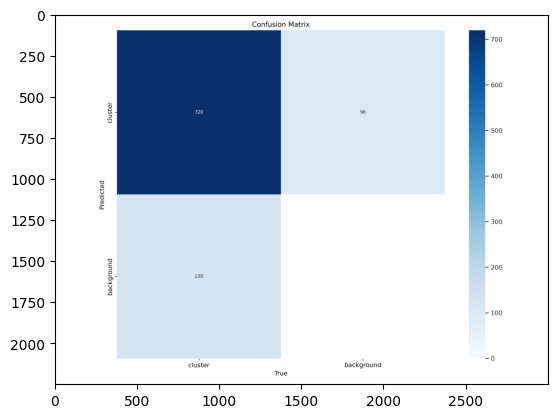

In [14]:
confusion_matrix = Image.open('runs/detect/val18/confusion_matrix.png')
plt.imshow(confusion_matrix)

## Modelo de Detecção de Uvas em um Cacho

### Preparação dos Dados

Paths dos diretórios de trabalho.

In [6]:
source_data_dir = Path('wgisd/data')
grapes_points_dir = Path('wgisd/contrib/berries')

clusters_dir = Path('wgisd/clusters')
clusters_dir.mkdir(exist_ok=True)

grapes_dataset_dir = Path('datasets/grapes')
grapes_train_dir = grapes_dataset_dir/'train'
grapes_val_dir = grapes_dataset_dir/'val'
grapes_test_dir = grapes_dataset_dir/'test'

model_path = Path('cluster_detection/v8s/weights/best.pt')

Lista com todas as imagens.

In [7]:
all_imgs_paths = list(source_data_dir.glob(f'*.jpg'))
all_imgs_names = [x.name[:-4] for x in all_imgs_paths]

- O dataset utilizado possui anotações de ponto para cada uva em um cacho.
- Cada cacho será cortado utilizando os "bounding boxes" determinados pelo modelo de detecção de cachos.
- Será construído um novo dataset somente com os cachos destacados. As imagens deste novo datasets serão anotadas com "bounding boxes" determinados a partir dos pontos anotados para cada uva. Abaixo podemos ver alguns exemplos das marcações de pontos.

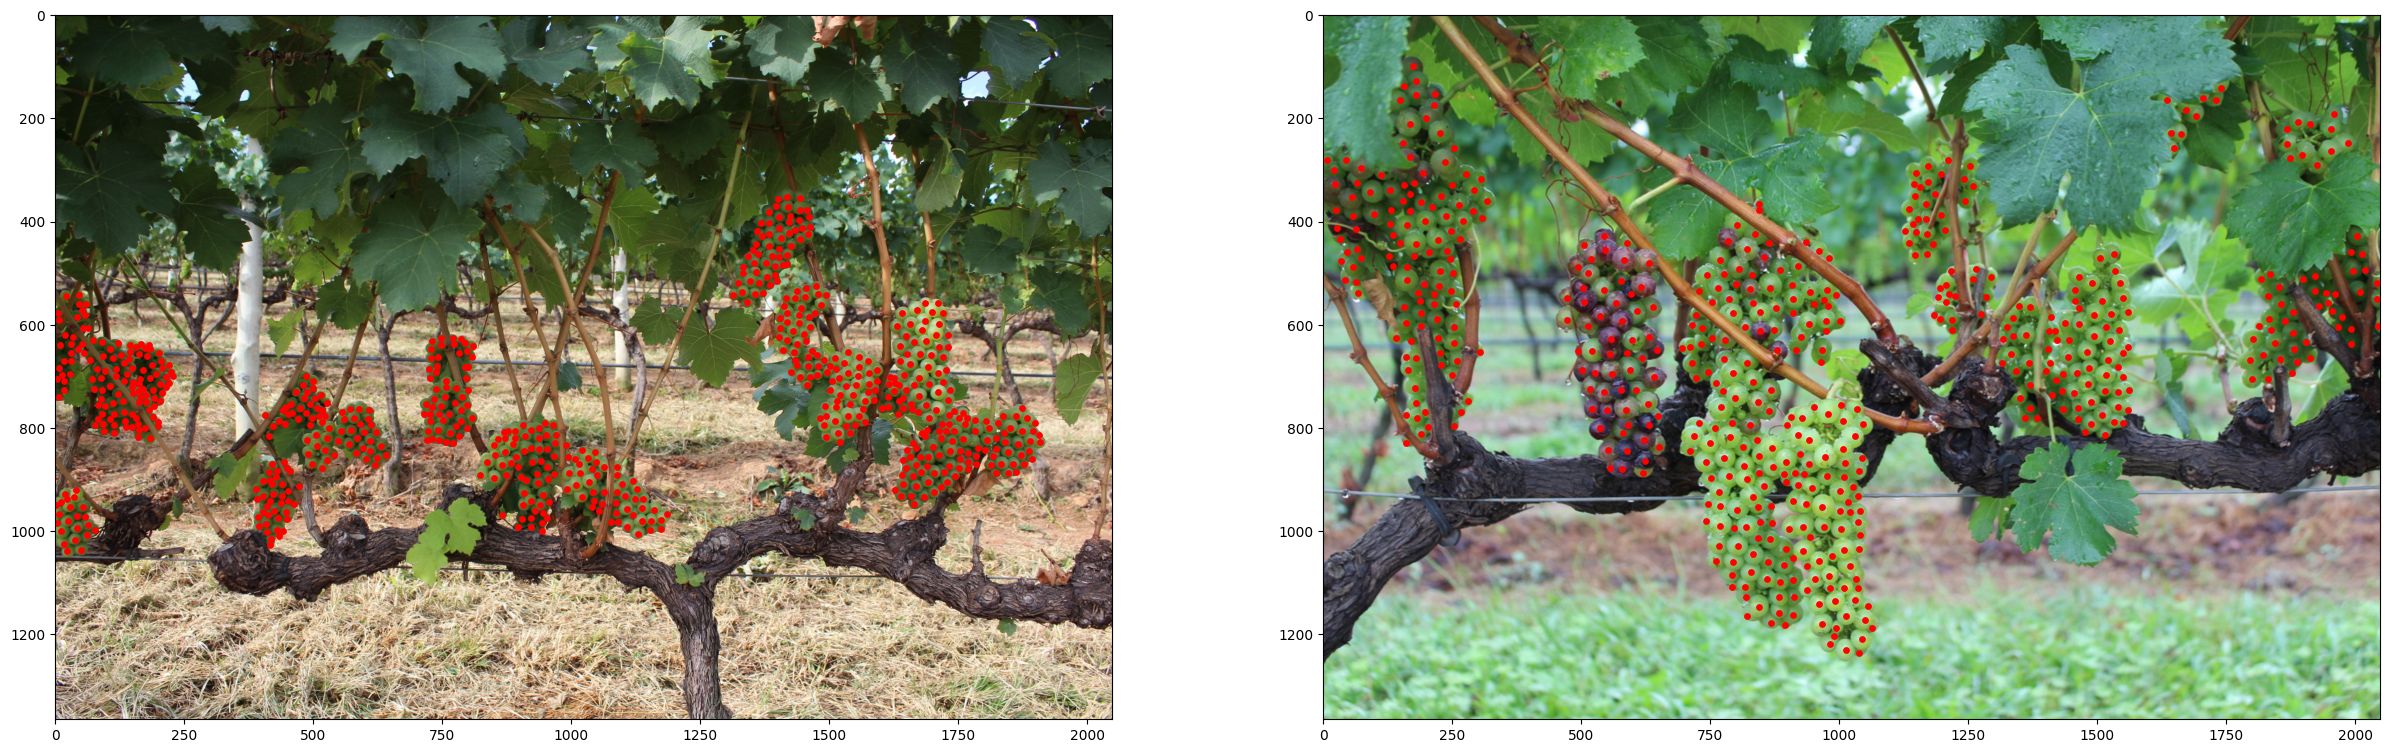

In [25]:
img_names = random.(train_imgs_names, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,30))

points1 = np.loadtxt(grapes_points_dir/f'{img_names[0]}-berries.txt').astype(int)
points2 = np.loadtxt(grapes_points_dir/f'{img_names[1]}-berries.txt').astype(int)

ax1.imshow(Image.open(source_data_dir/f'{img_names[0]}.jpg'))
ax1.scatter(points1[:,0], points1[:,1], color='r', s=15)

ax2.imshow(Image.open(source_data_dir/f'{img_names[1]}.jpg'))
ax2.scatter(points2[:,0], points2[:,1], color='r', s=15)

plt.show()

In [12]:
# Carrega modelo de detecção de cachos
cluster_detection_model = YOLO(model_path)

In [8]:
# Função para converter do formato xywh normalizado para o formato xyxy

def xywhnToXyxy(img, boxes):
    img_width = img.shape[1]
    img_height = img.shape[0]

    boxes[:, 0] = boxes[:, 0] * img_width
    boxes[:, 1] = boxes[:, 1] * img_height
    boxes[:, 2] = boxes[:, 2] * img_width
    boxes[:, 3] = boxes[:, 3] * img_height

    x, y, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    x0 = x - w / 2
    x1 = x + w / 2
    y0 = y - h / 2
    y1 = y + h / 2

    return np.column_stack((x0, y0, x1, y1))

O procedimento abaixo faz a extração de cada cacho e salva em uma imagem diferente. Para cada caixo são criados "bounding boxes" centrados nos pontos anotados para cada uva.

In [10]:
# Cria o dataset (imagens e labels) para a contagem de uvas por cacho.

for img_name in all_imgs_names:
    # Carrega os bounding boxes e pontos.
    img = cv2.cvtColor(cv2.imread(str(source_data_dir/f'{img_name}.jpg')), cv2.COLOR_BGR2RGB)
    grapes_points = np.loadtxt(grapes_points_dir/f'{img_name}-berries.txt').astype(int)

    #results = cluster_detection_model.predict(str(source_data_dir/f'{img_name}.jpg'), conf=0.4, iou=0.7, show=False)[0]
    #boxes = results.boxes.xyxy.cpu().tolist()

    boxes = np.loadtxt(source_data_dir/f'{img_name}.txt')[:,1:]
    boxes = xywhnToXyxy(img, boxes)
    
    new_box_params = list(range(4,13))
    
    # Para cada box.
    for i, box in enumerate(boxes):

        # Recorta a imagem delimitada pelo box.
        x1, x2, y1, y2 = int(box[0]), int(box[2]), int(box[1]), int(box[3])
        cropped_image = img[y1:y2, x1:x2]
        height, width = cropped_image.shape[:-1]

        min_dimension = min(cropped_image.shape[0], cropped_image.shape[1])

        points_detected = False
        
        # Para cada ponto.
        for point in grapes_points:
            
            px, py = point[0], point[1]

            # Se o ponto estiver dentro do box atual.
            if (px >= x1 and px <= x2) and (py >= y1 and py <= y2):
                # Mapeia o ponto para a nova imagem.
                px = px - x1
                py = py - y1

                # Determina as coordenadas do box centrado no ponto remapeado.
                h = int(min_dimension/new_box_params[min_dimension//100])/height
                w = int(min_dimension/new_box_params[min_dimension//100])/width

                # Salva a anotação do box no formado (classe x y w h) normalizado pelas dimensões da imagem.
                with open(clusters_dir/f'{img_name}-b{i}.txt', 'a') as f:
                    f.write(f'0 {px/width:.4f} {py/height:.4f} {w:.4f} {h:.4f}\n')

                points_detected = True

        # Salva a imagem do cacho extraído.
        if points_detected:
            _cropped_image = Image.fromarray(cropped_image, 'RGB')
            _cropped_image.save(clusters_dir/f'{img_name}-b{i}.jpg')

In [11]:
print(f'Imagens: {len(list(clusters_dir.iterdir()))}')

Imagens: 8774


Exemplos de imagens do novo dataset criado.

In [7]:
all_imgs_clusters = list(clusters_dir.glob('*.jpg'))

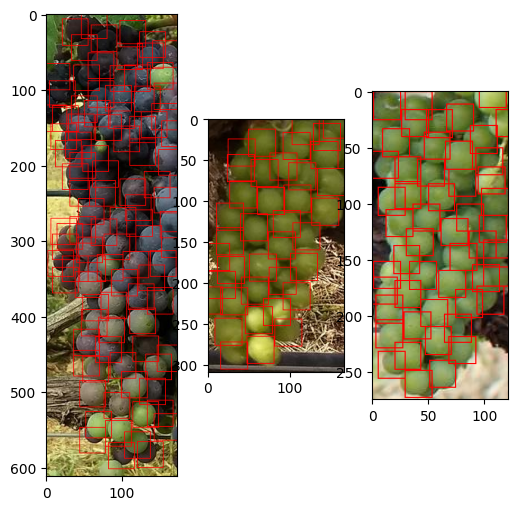

In [53]:
imgs = random.sample(all_imgs_clusters, 3)

image_1 = joinImageAndBoxes(f'{str(imgs[0])[:-4]}.jpg', f'{str(imgs[0])[:-4]}.txt', thickness=1)
image_2 = joinImageAndBoxes(f'{str(imgs[1])[:-4]}.jpg', f'{str(imgs[1])[:-4]}.txt', thickness=1)
image_3 = joinImageAndBoxes(f'{str(imgs[2])[:-4]}.jpg', f'{str(imgs[2])[:-4]}.txt', thickness=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,6))
ax1.imshow(image_1)
ax2.imshow(image_2)
ax3.imshow(image_3)
plt.show()

Cria a estrutura dos diretórios caso eles não existam

In [12]:
(grapes_train_dir/'images').mkdir(parents=True, exist_ok=True)
(grapes_train_dir/'labels').mkdir(parents=True, exist_ok=True)

(grapes_val_dir/'images').mkdir(parents=True, exist_ok=True)
(grapes_val_dir/'labels').mkdir(parents=True, exist_ok=True)

(grapes_test_dir/'images').mkdir(parents=True, exist_ok=True)
(grapes_test_dir/'labels').mkdir(parents=True, exist_ok=True)

In [ ]:
Copia os dados de treinamento, validação e teste para os seus respectivos diretórios

In [13]:
def copyToImagesLabelsDirsGrapes(imgs_names: list, dst_dir: Path):

    for image_name in imgs_names:
    
        imgs = list(clusters_dir.glob(f'{image_name}*.jpg'))
        lbs = list(clusters_dir.glob(f'{image_name}*.txt'))
    
        for i, l in zip(imgs, lbs):
            
            image_src_path = clusters_dir/i.name
            image_dst_path = dst_dir/'images'/i.name
    
            label_src_path = clusters_dir/l.name
            label_dst_path = dst_dir/'labels'/l.name
    
            shutil.copyfile(image_src_path, image_dst_path)
            shutil.copyfile(label_src_path, label_dst_path)

copyToImagesLabelsDirsGrapes(train_imgs_names, grapes_train_dir)
copyToImagesLabelsDirsGrapes(val_imgs_names, grapes_val_dir)
copyToImagesLabelsDirsGrapes(test_imgs_names, grapes_test_dir)

In [13]:
# Cria arquivo de configuração dos dados para treinamento

data_info = {'path': 'grapes',
             'train': 'train',
             'val': 'val',
             'test': 'test',
             'names': {'0': 'grape'}}

with open('grapes_data.yaml', 'w') as file:
    yaml.safe_dump(data_info, file)

### Treinamento do Modelo

Modelo será treinado a partir de um modelo pré-treinado

In [17]:
pre_trained_model_path = Path('yolov8n.pt')
grapes_detection_model = YOLO(pre_trained_model_path)

data_config_path = Path('grapes_data.yaml')
project_name = 'grapes_detection'
model_name = 'v8n2'

results = grapes_detection_model.train(data=data_config_path,
                                      project=project_name,
                                      name=model_name,
                                      epochs=200,
                                      imgsz=(256,256),
                                      patience=200,
                                      batch=32,
                                      pretrained=True,
                                      seed=0,
                                      single_cls=True,
                                      plots=True)

New https://pypi.org/project/ultralytics/8.1.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=grapes_data.yaml, epochs=200, time=None, patience=200, batch=32, imgsz=(256, 256), save=True, save_period=-1, cache=False, device=None, workers=8, project=grapes_detection, name=v8n2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

train: Scanning /home/leandro/projects/iot/yield_estimation/datasets/grapes/train/labels.cache... 2834 images, 0 backgrounds, 0 corrupt: 100%|██████████| 283

train: WARNING ⚠️ /home/leandro/projects/iot/yield_estimation/datasets/grapes/train/images/CFR_1628-b16.jpg: 1 duplicate labels removed



val: Scanning /home/leandro/projects/iot/yield_estimation/datasets/grapes/val/labels.cache... 731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 731/731 


Plotting labels to grapes_detection/v8n2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to grapes_detection/v8n2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.18G      2.533      2.307      1.448       1456        256: 100%|██████████| 89/89 [00:03<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.48it/s]

                   all        731      31436      0.638      0.651      0.635       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.15G      2.143      1.133      1.197       1983        256: 100%|██████████| 89/89 [00:02<00:00, 33.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.48it/s]

                   all        731      31436      0.745      0.778      0.801       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.33G      2.026     0.9673      1.177       1904        256: 100%|██████████| 89/89 [00:02<00:00, 36.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.26it/s]

                   all        731      31436      0.769      0.627       0.71       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200       1.9G      1.981     0.9475      1.176       1331        256: 100%|██████████| 89/89 [00:02<00:00, 38.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.25it/s]

                   all        731      31436       0.64      0.651      0.632      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.44G      1.928     0.9264      1.156       1554        256: 100%|██████████| 89/89 [00:02<00:00, 37.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.17it/s]


                   all        731      31436      0.799      0.817      0.856      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.17G      1.887      0.907      1.151       1245        256: 100%|██████████| 89/89 [00:02<00:00, 37.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.14it/s]

                   all        731      31436      0.837      0.809      0.873      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      1.82G      1.871     0.8968      1.141       1455        256: 100%|██████████| 89/89 [00:02<00:00, 37.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.81it/s]

                   all        731      31436      0.821       0.76      0.841      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      1.97G       1.84     0.8788      1.138       1458        256: 100%|██████████| 89/89 [00:02<00:00, 37.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.33it/s]

                   all        731      31436      0.815      0.769       0.83      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.77G      1.821     0.8732      1.131       1120        256: 100%|██████████| 89/89 [00:02<00:00, 37.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]

                   all        731      31436      0.874      0.809      0.899      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.24G      1.814     0.8641      1.127       1883        256: 100%|██████████| 89/89 [00:02<00:00, 37.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.96it/s]

                   all        731      31436      0.847      0.763      0.868      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      1.79G      1.803     0.8551      1.124       1537        256: 100%|██████████| 89/89 [00:02<00:00, 37.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.25it/s]


                   all        731      31436      0.817      0.805      0.861      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.16G      1.793     0.8563      1.121       1394        256: 100%|██████████| 89/89 [00:02<00:00, 37.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 12.68it/s]

                   all        731      31436      0.836      0.794      0.858      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/200      1.52G      1.773     0.8368      1.113       1575        256: 100%|██████████| 89/89 [00:02<00:00, 36.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.46it/s]

                   all        731      31436      0.858      0.815      0.894      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.28G      1.772     0.8399      1.113       1089        256: 100%|██████████| 89/89 [00:02<00:00, 36.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.12it/s]

                   all        731      31436      0.881      0.811      0.902      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.25G      1.776     0.8341      1.113       1685        256: 100%|██████████| 89/89 [00:02<00:00, 37.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.07it/s]

                   all        731      31436      0.838      0.751      0.816      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.07G      1.754     0.8252      1.105       1384        256: 100%|██████████| 89/89 [00:02<00:00, 36.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 12.86it/s]

                   all        731      31436      0.893      0.834      0.919      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.37G      1.763     0.8277      1.107       1279        256: 100%|██████████| 89/89 [00:02<00:00, 36.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.91it/s]

                   all        731      31436      0.864      0.846      0.905      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.85G      1.737      0.814      1.101       1324        256: 100%|██████████| 89/89 [00:02<00:00, 36.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00, 11.13it/s]

                   all        731      31436      0.879      0.844      0.914      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      1.77G      1.746     0.8092      1.104       1601        256: 100%|██████████| 89/89 [00:02<00:00, 37.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]

                   all        731      31436       0.86      0.799      0.885      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      1.83G      1.729     0.8111      1.101       1741        256: 100%|██████████| 89/89 [00:02<00:00, 37.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.18it/s]

                   all        731      31436      0.896      0.834      0.919      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.45G      1.743     0.8163      1.104       1325        256: 100%|██████████| 89/89 [00:02<00:00, 37.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.16it/s]

                   all        731      31436      0.883      0.858      0.922      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      1.41G      1.725     0.8088      1.098       1532        256: 100%|██████████| 89/89 [00:02<00:00, 37.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.27it/s]

                   all        731      31436      0.877      0.833      0.903      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.99G      1.727     0.8077      1.096       1325        256: 100%|██████████| 89/89 [00:02<00:00, 37.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.52it/s]

                   all        731      31436      0.879      0.855      0.919       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.02G       1.73     0.8127      1.101       1719        256: 100%|██████████| 89/89 [00:02<00:00, 37.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.24it/s]

                   all        731      31436      0.899      0.853       0.93      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      1.61G      1.714     0.7942      1.093       1232        256: 100%|██████████| 89/89 [00:02<00:00, 37.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.77it/s]

                   all        731      31436      0.899      0.847      0.926      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.75G      1.714     0.7922      1.096       1535        256: 100%|██████████| 89/89 [00:02<00:00, 36.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 12.56it/s]

                   all        731      31436      0.896      0.854      0.925      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.24G        1.7     0.7968      1.095       1649        256: 100%|██████████| 89/89 [00:02<00:00, 37.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]

                   all        731      31436      0.887      0.865       0.93      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      1.76G        1.7     0.7909      1.093       1980        256: 100%|██████████| 89/89 [00:02<00:00, 37.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]

                   all        731      31436      0.898      0.862      0.935      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      1.78G      1.689     0.7807      1.085       1713        256: 100%|██████████| 89/89 [00:02<00:00, 37.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.36it/s]


                   all        731      31436      0.903       0.86      0.932      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       1.8G      1.691     0.7858       1.09       1443        256: 100%|██████████| 89/89 [00:02<00:00, 37.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.02it/s]

                   all        731      31436      0.889      0.859      0.927      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      1.98G      1.688     0.7809      1.086       1744        256: 100%|██████████| 89/89 [00:02<00:00, 37.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.92it/s]

                   all        731      31436       0.88      0.853      0.916      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      1.98G      1.674     0.7776      1.085       1009        256: 100%|██████████| 89/89 [00:02<00:00, 37.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.18it/s]

                   all        731      31436      0.901      0.869      0.941      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.56G      1.687     0.7711      1.086       1363        256: 100%|██████████| 89/89 [00:02<00:00, 37.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.29it/s]

                   all        731      31436      0.892      0.868      0.932       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.38G      1.696     0.7783       1.09       1295        256: 100%|██████████| 89/89 [00:02<00:00, 37.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.50it/s]

                   all        731      31436      0.912      0.859      0.938      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      1.71G      1.684      0.771      1.084       1598        256: 100%|██████████| 89/89 [00:02<00:00, 37.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.25it/s]


                   all        731      31436      0.905       0.86      0.936      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      1.41G      1.673     0.7712      1.082       1230        256: 100%|██████████| 89/89 [00:02<00:00, 37.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.04it/s]

                   all        731      31436      0.912      0.856      0.939       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.02G      1.673     0.7723      1.084       1525        256: 100%|██████████| 89/89 [00:02<00:00, 37.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]

                   all        731      31436      0.908       0.85      0.932      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.29G      1.674     0.7664      1.079       1712        256: 100%|██████████| 89/89 [00:02<00:00, 37.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.43it/s]

                   all        731      31436      0.902      0.867      0.937      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.01G       1.66     0.7636      1.079       1132        256: 100%|██████████| 89/89 [00:02<00:00, 37.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.18it/s]

                   all        731      31436        0.9      0.861      0.931       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.27G      1.656     0.7619      1.078       1341        256: 100%|██████████| 89/89 [00:02<00:00, 37.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.39it/s]

                   all        731      31436      0.909      0.866      0.941       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      1.78G      1.664      0.761      1.079       1571        256: 100%|██████████| 89/89 [00:02<00:00, 37.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.00it/s]

                   all        731      31436      0.913      0.869      0.943      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      1.59G      1.664     0.7576      1.078       1433        256: 100%|██████████| 89/89 [00:02<00:00, 36.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.64it/s]

                   all        731      31436      0.917      0.871      0.945      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      1.54G      1.682     0.7676      1.078       1653        256: 100%|██████████| 89/89 [00:02<00:00, 37.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.63it/s]

                   all        731      31436      0.885      0.872      0.931      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      1.85G      1.647     0.7612      1.075       1715        256: 100%|██████████| 89/89 [00:02<00:00, 37.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.69it/s]

                   all        731      31436      0.904      0.861      0.935      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.58G      1.642     0.7491      1.076       1349        256: 100%|██████████| 89/89 [00:02<00:00, 37.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.88it/s]

                   all        731      31436      0.905      0.875      0.941      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      1.37G      1.647     0.7543      1.078       1626        256: 100%|██████████| 89/89 [00:02<00:00, 36.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.73it/s]

                   all        731      31436      0.896      0.866      0.935       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.19G      1.657     0.7614       1.08       1426        256: 100%|██████████| 89/89 [00:02<00:00, 36.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.98it/s]

                   all        731      31436      0.899      0.873      0.935      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.04G      1.657     0.7591       1.08       2053        256: 100%|██████████| 89/89 [00:02<00:00, 36.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.12it/s]

                   all        731      31436      0.916      0.873      0.945      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.67G      1.643     0.7515      1.077       1523        256: 100%|██████████| 89/89 [00:02<00:00, 37.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.01it/s]

                   all        731      31436      0.909      0.872      0.941      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       1.6G      1.652     0.7566      1.072       1430        256: 100%|██████████| 89/89 [00:02<00:00, 37.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.38it/s]

                   all        731      31436      0.914      0.868      0.941       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      1.69G      1.639       0.75      1.068       1525        256: 100%|██████████| 89/89 [00:02<00:00, 37.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.43it/s]

                   all        731      31436      0.903      0.881      0.942      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      1.94G      1.635     0.7477      1.067       1985        256: 100%|██████████| 89/89 [00:02<00:00, 37.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.01it/s]

                   all        731      31436      0.912      0.873      0.942      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      1.61G       1.63     0.7489      1.071       1306        256: 100%|██████████| 89/89 [00:02<00:00, 38.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.69it/s]

                   all        731      31436       0.91      0.878      0.942       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      1.83G      1.627     0.7437       1.07       1708        256: 100%|██████████| 89/89 [00:02<00:00, 37.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.80it/s]

                   all        731      31436      0.909      0.878      0.946      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.82G      1.637     0.7487      1.074       1856        256: 100%|██████████| 89/89 [00:02<00:00, 37.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.72it/s]

                   all        731      31436      0.907       0.87      0.941      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.26G      1.626     0.7466      1.072       1403        256: 100%|██████████| 89/89 [00:02<00:00, 37.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.45it/s]

                   all        731      31436      0.909      0.866      0.939       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/200       2.2G      1.637     0.7449       1.07       1614        256: 100%|██████████| 89/89 [00:02<00:00, 37.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.90it/s]


                   all        731      31436      0.908      0.881      0.946       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.75G      1.626     0.7439      1.068       1464        256: 100%|██████████| 89/89 [00:02<00:00, 37.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.28it/s]

                   all        731      31436      0.909      0.869       0.94      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      1.58G      1.618     0.7407      1.073       2029        256: 100%|██████████| 89/89 [00:02<00:00, 38.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.01it/s]

                   all        731      31436      0.913      0.877      0.947      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.87G      1.642     0.7399      1.072       1473        256: 100%|██████████| 89/89 [00:02<00:00, 37.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.29it/s]

                   all        731      31436      0.908      0.885      0.948      0.547


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.13G      1.608     0.7296      1.062       1271        256: 100%|██████████| 89/89 [00:02<00:00, 37.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.14it/s]

                   all        731      31436      0.915      0.883      0.949      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      1.33G       1.62     0.7401      1.066       1387        256: 100%|██████████| 89/89 [00:02<00:00, 37.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 2/12 [00:00<00:00, 13.61it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c

                   all        731      31436      0.903      0.865      0.942      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.05G      1.628     0.7334      1.067       2159        256: 100%|██████████| 89/89 [00:02<00:00, 37.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.78it/s]

                   all        731      31436      0.913      0.874      0.944      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      1.42G      1.615     0.7354       1.07       1665        256: 100%|██████████| 89/89 [00:02<00:00, 38.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.74it/s]

                   all        731      31436       0.92      0.869      0.945      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      1.98G      1.622     0.7345       1.07       1222        256: 100%|██████████| 89/89 [00:02<00:00, 37.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.92it/s]

                   all        731      31436      0.913      0.871      0.944      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      1.89G      1.625      0.735      1.071       1215        256: 100%|██████████| 89/89 [00:02<00:00, 37.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.53it/s]

                   all        731      31436      0.915      0.872      0.945      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.15G      1.614     0.7282      1.061       1352        256: 100%|██████████| 89/89 [00:02<00:00, 37.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.21it/s]

                   all        731      31436      0.908      0.874      0.941      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.05G       1.61      0.731      1.062       1893        256: 100%|██████████| 89/89 [00:02<00:00, 36.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.92it/s]

                   all        731      31436      0.904      0.884      0.943      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      1.55G       1.61      0.732      1.061       1611        256: 100%|██████████| 89/89 [00:02<00:00, 36.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.73it/s]


                   all        731      31436      0.909      0.873      0.944      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.92G      1.597     0.7267      1.059       1091        256: 100%|██████████| 89/89 [00:02<00:00, 37.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.82it/s]

                   all        731      31436       0.92      0.881      0.949      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.65G      1.614     0.7319      1.063       1760        256: 100%|██████████| 89/89 [00:02<00:00, 36.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.26it/s]

                   all        731      31436      0.914      0.876      0.947      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      1.68G      1.601     0.7208      1.058       1461        256: 100%|██████████| 89/89 [00:02<00:00, 37.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.56it/s]

                   all        731      31436      0.915       0.88      0.948       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.42G      1.599     0.7251      1.061       1222        256: 100%|██████████| 89/89 [00:02<00:00, 37.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.46it/s]

                   all        731      31436      0.916      0.877      0.948       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.32G      1.596     0.7261      1.062       1710        256: 100%|██████████| 89/89 [00:02<00:00, 37.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 12.46it/s]

                   all        731      31436      0.909      0.888       0.95      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      1.34G      1.593     0.7233       1.06       1386        256: 100%|██████████| 89/89 [00:02<00:00, 37.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.26it/s]

                   all        731      31436      0.913       0.88      0.947      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.28G      1.604     0.7239      1.061       1776        256: 100%|██████████| 89/89 [00:02<00:00, 37.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.44it/s]

                   all        731      31436      0.918      0.878      0.947      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.24G      1.602      0.727      1.062       1429        256: 100%|██████████| 89/89 [00:02<00:00, 37.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.54it/s]

                   all        731      31436      0.911      0.878      0.945      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       1.5G      1.593     0.7207      1.062       1441        256: 100%|██████████| 89/89 [00:02<00:00, 37.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.12it/s]

                   all        731      31436      0.914      0.875      0.947      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.22G      1.592     0.7223      1.059       1441        256: 100%|██████████| 89/89 [00:02<00:00, 35.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.24it/s]

                   all        731      31436      0.912      0.884      0.949      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      1.54G       1.59     0.7212      1.061       1382        256: 100%|██████████| 89/89 [00:02<00:00, 37.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.17it/s]

                   all        731      31436      0.913      0.886      0.948      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.19G        1.6     0.7223       1.06       1519        256: 100%|██████████| 89/89 [00:02<00:00, 37.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.39it/s]

                   all        731      31436      0.918      0.879       0.95      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.29G      1.585      0.721       1.06       1690        256: 100%|██████████| 89/89 [00:02<00:00, 37.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.53it/s]

                   all        731      31436       0.92      0.877      0.951      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      1.69G      1.595     0.7198      1.059       1329        256: 100%|██████████| 89/89 [00:02<00:00, 37.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.37it/s]

                   all        731      31436      0.918      0.887      0.953      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.18G      1.578     0.7124      1.055       1332        256: 100%|██████████| 89/89 [00:02<00:00, 37.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.27it/s]

                   all        731      31436      0.915      0.881      0.949      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      1.92G      1.572     0.7091       1.05       1768        256: 100%|██████████| 89/89 [00:02<00:00, 37.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.45it/s]

                   all        731      31436      0.917      0.883      0.952      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.19G      1.575     0.7088      1.056       1533        256: 100%|██████████| 89/89 [00:02<00:00, 37.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.77it/s]

                   all        731      31436       0.92      0.885      0.951      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      1.87G      1.582     0.7127      1.056       1742        256: 100%|██████████| 89/89 [00:02<00:00, 37.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.58it/s]

                   all        731      31436      0.916      0.884      0.949       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.08G      1.582     0.7111      1.058       1425        256: 100%|██████████| 89/89 [00:02<00:00, 37.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.43it/s]

                   all        731      31436      0.911      0.889      0.951      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.45G      1.568     0.7074      1.053       1606        256: 100%|██████████| 89/89 [00:02<00:00, 36.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.88it/s]

                   all        731      31436      0.918      0.881       0.95       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      1.72G       1.57     0.7055       1.05       1444        256: 100%|██████████| 89/89 [00:02<00:00, 37.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.63it/s]

                   all        731      31436      0.913      0.881      0.948      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      1.55G      1.576      0.711      1.054       1539        256: 100%|██████████| 89/89 [00:02<00:00, 37.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.57it/s]

                   all        731      31436      0.915      0.882      0.951      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      1.85G      1.572     0.7107      1.056       1550        256: 100%|██████████| 89/89 [00:02<00:00, 37.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.69it/s]

                   all        731      31436      0.917      0.873      0.946      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      1.78G      1.566     0.7042      1.047       1183        256: 100%|██████████| 89/89 [00:02<00:00, 38.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.34it/s]

                   all        731      31436      0.911      0.886      0.948      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      1.84G      1.571     0.7103      1.056       1748        256: 100%|██████████| 89/89 [00:02<00:00, 38.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.33it/s]


                   all        731      31436       0.92      0.888      0.953      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      1.44G       1.57      0.708      1.054       1339        256: 100%|██████████| 89/89 [00:02<00:00, 37.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.49it/s]

                   all        731      31436      0.913      0.886      0.951      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.04G      1.562     0.7053      1.051       1783        256: 100%|██████████| 89/89 [00:02<00:00, 37.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.34it/s]

                   all        731      31436      0.918      0.884       0.95      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      1.65G      1.558     0.7039      1.051       1649        256: 100%|██████████| 89/89 [00:02<00:00, 37.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.73it/s]

                   all        731      31436      0.916      0.891      0.951      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.62G      1.567     0.7069      1.051       1638        256: 100%|██████████| 89/89 [00:02<00:00, 37.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.44it/s]

                   all        731      31436      0.915      0.885      0.952      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.18G      1.562     0.7031      1.051       1496        256: 100%|██████████| 89/89 [00:02<00:00, 37.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.50it/s]

                   all        731      31436      0.919      0.882      0.951      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      1.91G      1.561     0.7082      1.051       1250        256: 100%|██████████| 89/89 [00:02<00:00, 37.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.86it/s]

                   all        731      31436      0.918       0.89      0.953       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      1.92G      1.575     0.7103      1.053       1208        256: 100%|██████████| 89/89 [00:02<00:00, 37.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.31it/s]

                   all        731      31436      0.916      0.891      0.952      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      1.55G      1.568     0.7062      1.051       1790        256: 100%|██████████| 89/89 [00:02<00:00, 36.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 12.79it/s]

                   all        731      31436       0.92      0.882      0.952      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      1.82G      1.559     0.7029      1.051       1316        256: 100%|██████████| 89/89 [00:02<00:00, 37.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.68it/s]

                   all        731      31436       0.92      0.888      0.953      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.84G       1.56     0.6994      1.051       1715        256: 100%|██████████| 89/89 [00:02<00:00, 37.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 6/12 [00:00<00:00, 14.16it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c

                   all        731      31436      0.918      0.891      0.952      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200       1.9G      1.561     0.7001       1.05       1780        256: 100%|██████████| 89/89 [00:02<00:00, 36.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 6/12 [00:00<00:00, 14.64it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c

                   all        731      31436      0.921       0.89      0.954      0.563


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>

Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.05G      1.556     0.6976       1.05       1271        256: 100%|██████████| 89/89 [00:02<00:00, 37.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 8/12 [00:00<00:00, 14.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c

                   all        731      31436      0.919      0.887      0.953      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      1.72G      1.547     0.6982       1.05       1685        256: 100%|██████████| 89/89 [00:02<00:00, 37.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.55it/s]

                   all        731      31436      0.919      0.888      0.953      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      1.57G      1.553     0.6979       1.05       1228        256: 100%|██████████| 89/89 [00:02<00:00, 37.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 2/12 [00:00<00:00, 13.94it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c

                   all        731      31436      0.919       0.89      0.953      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      1.98G      1.558     0.7007      1.046       1524        256: 100%|██████████| 89/89 [00:02<00:00, 37.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.54it/s]

                   all        731      31436      0.922      0.888      0.954      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      1.62G      1.551     0.6997      1.048       1632        256: 100%|██████████| 89/89 [00:02<00:00, 37.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.30it/s]

                   all        731      31436      0.913      0.887      0.951      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      1.64G      1.543     0.6922      1.048       1647        256: 100%|██████████| 89/89 [00:02<00:00, 38.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.69it/s]

                   all        731      31436      0.921       0.89      0.954      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.04G       1.56     0.6948      1.048       1333        256: 100%|██████████| 89/89 [00:02<00:00, 37.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.57it/s]

                   all        731      31436      0.917       0.89      0.954      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.51G      1.549     0.6928      1.046       1710        256: 100%|██████████| 89/89 [00:02<00:00, 37.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.14it/s]

                   all        731      31436       0.92      0.889      0.954      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.14G      1.554     0.6926      1.049       1695        256: 100%|██████████| 89/89 [00:02<00:00, 36.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.79it/s]

                   all        731      31436      0.918      0.893      0.954      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      1.82G      1.552     0.6973      1.049       1511        256: 100%|██████████| 89/89 [00:02<00:00, 37.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.60it/s]

                   all        731      31436      0.917      0.891      0.955      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.65G      1.543     0.6914      1.046       1426        256: 100%|██████████| 89/89 [00:02<00:00, 37.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.47it/s]

                   all        731      31436       0.92       0.89      0.955      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.39G      1.545     0.6922      1.043       1747        256: 100%|██████████| 89/89 [00:02<00:00, 37.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.03it/s]

                   all        731      31436      0.921       0.89      0.956      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.21G      1.545     0.6942      1.046       1283        256: 100%|██████████| 89/89 [00:02<00:00, 37.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.47it/s]

                   all        731      31436       0.92      0.891      0.954      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.47G      1.539     0.6907      1.044       1714        256: 100%|██████████| 89/89 [00:02<00:00, 37.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.55it/s]

                   all        731      31436       0.92      0.887      0.953      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       2.2G      1.538     0.6909      1.044       1320        256: 100%|██████████| 89/89 [00:02<00:00, 37.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.47it/s]

                   all        731      31436      0.916      0.896      0.952      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      1.93G      1.541     0.6884      1.046       1764        256: 100%|██████████| 89/89 [00:02<00:00, 37.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.23it/s]

                   all        731      31436      0.926       0.89      0.955       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.11G      1.542     0.6901      1.047       1464        256: 100%|██████████| 89/89 [00:02<00:00, 36.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.00it/s]

                   all        731      31436      0.919      0.889      0.953      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      1.77G      1.538      0.692      1.046       1104        256: 100%|██████████| 89/89 [00:02<00:00, 35.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.22it/s]

                   all        731      31436      0.918      0.895      0.955      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.05G      1.537     0.6867      1.044       1790        256: 100%|██████████| 89/89 [00:02<00:00, 37.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.45it/s]

                   all        731      31436       0.92      0.891      0.955      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.32G      1.542     0.6895      1.049       1166        256: 100%|██████████| 89/89 [00:02<00:00, 37.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.80it/s]

                   all        731      31436      0.919      0.892      0.956      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.62G      1.543      0.692      1.046       1511        256: 100%|██████████| 89/89 [00:02<00:00, 37.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.83it/s]

                   all        731      31436      0.919      0.895      0.956      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.16G      1.529     0.6884      1.044       1612        256: 100%|██████████| 89/89 [00:02<00:00, 37.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.73it/s]

                   all        731      31436      0.919      0.892      0.955      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200       2.3G      1.533     0.6838      1.044       1856        256: 100%|██████████| 89/89 [00:02<00:00, 37.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.81it/s]

                   all        731      31436      0.924      0.887      0.955      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      1.81G      1.529     0.6859      1.041       1649        256: 100%|██████████| 89/89 [00:02<00:00, 36.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.17it/s]

                   all        731      31436      0.916      0.897      0.954      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.19G      1.538     0.6909      1.045       1453        256: 100%|██████████| 89/89 [00:02<00:00, 37.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.70it/s]

                   all        731      31436      0.917      0.895      0.955      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      1.94G      1.526     0.6855      1.044       1355        256: 100%|██████████| 89/89 [00:02<00:00, 37.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.63it/s]

                   all        731      31436      0.922      0.894      0.956       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      1.48G      1.538     0.6889      1.043       1568        256: 100%|██████████| 89/89 [00:02<00:00, 37.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.67it/s]

                   all        731      31436       0.92      0.897      0.956      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.11G      1.532     0.6853      1.039       1352        256: 100%|██████████| 89/89 [00:02<00:00, 37.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.68it/s]

                   all        731      31436       0.92      0.895      0.955      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.33G       1.54     0.6872      1.045       1244        256: 100%|██████████| 89/89 [00:02<00:00, 36.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.71it/s]

                   all        731      31436       0.92      0.895      0.955      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.34G       1.53     0.6854      1.044       1416        256: 100%|██████████| 89/89 [00:02<00:00, 37.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.62it/s]

                   all        731      31436      0.923      0.894      0.956       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      1.82G      1.528     0.6824      1.044       1227        256: 100%|██████████| 89/89 [00:02<00:00, 37.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.86it/s]

                   all        731      31436      0.922      0.895      0.956      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      1.53G      1.536     0.6874      1.043       1216        256: 100%|██████████| 89/89 [00:02<00:00, 37.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.80it/s]

                   all        731      31436      0.921      0.893      0.956      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      1.86G      1.522     0.6806       1.04       1536        256: 100%|██████████| 89/89 [00:02<00:00, 37.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.87it/s]

                   all        731      31436      0.921      0.895      0.956      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.18G      1.528     0.6804       1.04       1445        256: 100%|██████████| 89/89 [00:02<00:00, 37.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.73it/s]

                   all        731      31436      0.922      0.895      0.957      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.06G      1.527       0.68      1.038       1792        256: 100%|██████████| 89/89 [00:02<00:00, 37.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.59it/s]

                   all        731      31436      0.922      0.894      0.955      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      1.56G      1.518      0.678      1.037       1522        256: 100%|██████████| 89/89 [00:02<00:00, 37.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.72it/s]

                   all        731      31436      0.923      0.893      0.956      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      1.59G      1.515     0.6809      1.039       1435        256: 100%|██████████| 89/89 [00:02<00:00, 37.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.85it/s]

                   all        731      31436      0.917      0.897      0.956      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.52G      1.524     0.6818      1.044       1413        256: 100%|██████████| 89/89 [00:02<00:00, 37.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.78it/s]

                   all        731      31436       0.92      0.897      0.956      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200       1.8G      1.521     0.6761      1.037       1710        256: 100%|██████████| 89/89 [00:02<00:00, 37.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.64it/s]

                   all        731      31436       0.92      0.896      0.956      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      1.46G      1.522     0.6768       1.04       1546        256: 100%|██████████| 89/89 [00:02<00:00, 37.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.81it/s]

                   all        731      31436      0.923      0.893      0.956      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.06G      1.521      0.681       1.04       1580        256: 100%|██████████| 89/89 [00:02<00:00, 36.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.73it/s]

                   all        731      31436      0.922      0.898      0.956      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      1.63G      1.517     0.6786      1.035       1235        256: 100%|██████████| 89/89 [00:02<00:00, 37.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.53it/s]

                   all        731      31436      0.922      0.895      0.956      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      1.44G      1.505     0.6769      1.039       1297        256: 100%|██████████| 89/89 [00:02<00:00, 36.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.71it/s]

                   all        731      31436      0.921      0.898      0.957      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      1.17G      1.508     0.6758      1.036       1802        256: 100%|██████████| 89/89 [00:02<00:00, 37.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.79it/s]

                   all        731      31436      0.922      0.897      0.956      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       2.2G      1.513     0.6772       1.04       1722        256: 100%|██████████| 89/89 [00:02<00:00, 37.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.86it/s]

                   all        731      31436       0.92      0.896      0.956      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200       2.2G      1.519     0.6824       1.04       1600        256: 100%|██████████| 89/89 [00:02<00:00, 37.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 10/12 [00:00<00:00, 14.22it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6c430>
Traceback (most recent call last):
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/leandro/projects/.virtualenvs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e60eaf6

                   all        731      31436      0.921      0.896      0.956      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.51G       1.51     0.6749      1.035       1671        256: 100%|██████████| 89/89 [00:02<00:00, 36.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.14it/s]

                   all        731      31436      0.921      0.897      0.957      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200       2.1G      1.516     0.6726      1.037       1799        256: 100%|██████████| 89/89 [00:02<00:00, 37.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.86it/s]

                   all        731      31436      0.923      0.894      0.957      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.49G      1.511     0.6724      1.041       1373        256: 100%|██████████| 89/89 [00:02<00:00, 37.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.44it/s]

                   all        731      31436      0.923      0.895      0.957      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      1.85G      1.504     0.6703      1.032       1190        256: 100%|██████████| 89/89 [00:02<00:00, 38.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.08it/s]

                   all        731      31436      0.924      0.895      0.957      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.04G      1.514     0.6776      1.039       1332        256: 100%|██████████| 89/89 [00:02<00:00, 37.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.53it/s]

                   all        731      31436      0.923      0.897      0.957      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      1.87G      1.498     0.6732      1.037       1569        256: 100%|██████████| 89/89 [00:02<00:00, 37.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.75it/s]

                   all        731      31436      0.923      0.899      0.958      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.19G      1.502     0.6704      1.035       1261        256: 100%|██████████| 89/89 [00:02<00:00, 37.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.58it/s]

                   all        731      31436      0.922      0.898      0.958      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.01G      1.513     0.6745      1.032       1361        256: 100%|██████████| 89/89 [00:02<00:00, 37.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.89it/s]

                   all        731      31436      0.922      0.898      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      1.68G      1.505     0.6707      1.036       1199        256: 100%|██████████| 89/89 [00:02<00:00, 37.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.87it/s]

                   all        731      31436      0.921      0.899      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      1.87G      1.505     0.6684       1.03       1498        256: 100%|██████████| 89/89 [00:02<00:00, 36.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.59it/s]

                   all        731      31436      0.924      0.899      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200         2G      1.502     0.6715      1.033       1621        256: 100%|██████████| 89/89 [00:02<00:00, 37.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.84it/s]

                   all        731      31436      0.922      0.897      0.956      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.18G      1.505     0.6716      1.033       1703        256: 100%|██████████| 89/89 [00:02<00:00, 38.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.76it/s]

                   all        731      31436      0.922      0.896      0.956      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.44G      1.489     0.6657       1.03       1271        256: 100%|██████████| 89/89 [00:02<00:00, 37.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.82it/s]

                   all        731      31436      0.923      0.897      0.956      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      1.73G      1.502     0.6714      1.033       1198        256: 100%|██████████| 89/89 [00:02<00:00, 37.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.57it/s]

                   all        731      31436      0.923      0.896      0.956      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.02G      1.497     0.6731      1.037       1304        256: 100%|██████████| 89/89 [00:02<00:00, 37.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.85it/s]

                   all        731      31436      0.923      0.896      0.957      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      1.59G      1.498     0.6634      1.034       1527        256: 100%|██████████| 89/89 [00:02<00:00, 37.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.78it/s]

                   all        731      31436      0.922      0.898      0.957      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      1.81G      1.501     0.6691      1.033       1778        256: 100%|██████████| 89/89 [00:02<00:00, 37.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.83it/s]

                   all        731      31436      0.922      0.899      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.45G      1.482     0.6634      1.028       1609        256: 100%|██████████| 89/89 [00:02<00:00, 37.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.83it/s]

                   all        731      31436      0.923      0.899      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.34G      1.497     0.6678      1.034       1759        256: 100%|██████████| 89/89 [00:02<00:00, 37.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.90it/s]

                   all        731      31436      0.922        0.9      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      1.87G      1.496      0.668      1.034       1582        256: 100%|██████████| 89/89 [00:02<00:00, 37.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.86it/s]

                   all        731      31436      0.922        0.9      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.08G      1.488      0.664      1.029       1131        256: 100%|██████████| 89/89 [00:02<00:00, 37.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.83it/s]

                   all        731      31436      0.922        0.9      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.52G      1.489     0.6638      1.028       1404        256: 100%|██████████| 89/89 [00:02<00:00, 37.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.93it/s]

                   all        731      31436      0.924      0.899      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      1.79G      1.491     0.6646      1.036       1356        256: 100%|██████████| 89/89 [00:02<00:00, 37.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.49it/s]

                   all        731      31436      0.924      0.898      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      1.88G      1.485     0.6608      1.027       1053        256: 100%|██████████| 89/89 [00:02<00:00, 37.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.06it/s]

                   all        731      31436      0.923      0.898      0.958      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      1.96G      1.498     0.6692      1.034       1533        256: 100%|██████████| 89/89 [00:02<00:00, 37.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.41it/s]

                   all        731      31436       0.92      0.901      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      1.94G      1.499     0.6686       1.03       1710        256: 100%|██████████| 89/89 [00:02<00:00, 37.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.75it/s]

                   all        731      31436      0.921      0.902      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.19G      1.489     0.6641      1.032       1557        256: 100%|██████████| 89/89 [00:02<00:00, 37.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.88it/s]

                   all        731      31436      0.922        0.9      0.958      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      1.49G      1.482       0.66       1.03       1637        256: 100%|██████████| 89/89 [00:02<00:00, 37.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.85it/s]

                   all        731      31436      0.923        0.9      0.958      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.41G       1.49     0.6627      1.031       1450        256: 100%|██████████| 89/89 [00:02<00:00, 36.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.84it/s]

                   all        731      31436      0.922        0.9      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      1.81G      1.483     0.6656       1.03       1236        256: 100%|██████████| 89/89 [00:02<00:00, 37.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.78it/s]

                   all        731      31436      0.922      0.901      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.01G      1.477     0.6585      1.028       1180        256: 100%|██████████| 89/89 [00:02<00:00, 37.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.93it/s]


                   all        731      31436      0.923      0.899      0.958      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      1.46G      1.477      0.659      1.027       1264        256: 100%|██████████| 89/89 [00:02<00:00, 38.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.81it/s]

                   all        731      31436      0.922      0.901      0.958      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.19G      1.475     0.6589      1.029       1427        256: 100%|██████████| 89/89 [00:02<00:00, 38.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.82it/s]

                   all        731      31436      0.924        0.9      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      1.87G      1.472     0.6548      1.022       1276        256: 100%|██████████| 89/89 [00:02<00:00, 38.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.60it/s]

                   all        731      31436      0.924      0.902      0.958      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.51G      1.487     0.6627      1.031       1514        256: 100%|██████████| 89/89 [00:02<00:00, 36.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.87it/s]

                   all        731      31436      0.923      0.901      0.958      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.02G      1.484     0.6611      1.028       1464        256: 100%|██████████| 89/89 [00:02<00:00, 38.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.26it/s]

                   all        731      31436      0.922      0.902      0.958      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    188/200      1.85G      1.486     0.6588      1.028       1781        256: 100%|██████████| 89/89 [00:02<00:00, 37.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.74it/s]

                   all        731      31436      0.923        0.9      0.958      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      1.35G      1.471     0.6563      1.026       1299        256: 100%|██████████| 89/89 [00:02<00:00, 37.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.87it/s]

                   all        731      31436      0.924        0.9      0.958      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       1.6G      1.471     0.6575      1.026       1424        256: 100%|██████████| 89/89 [00:02<00:00, 38.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.97it/s]

                   all        731      31436      0.923        0.9      0.958      0.577


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200       1.3G      1.382     0.6536      1.034        744        256: 100%|██████████| 89/89 [00:02<00:00, 31.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.29it/s]

                   all        731      31436      0.922        0.9      0.956      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      1.35G      1.337     0.6257       1.02        789        256: 100%|██████████| 89/89 [00:02<00:00, 39.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.87it/s]

                   all        731      31436      0.921      0.899      0.955       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      1.31G      1.328     0.6207      1.013        649        256: 100%|██████████| 89/89 [00:02<00:00, 40.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.95it/s]

                   all        731      31436       0.92        0.9      0.955      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      1.34G      1.329     0.6223      1.015        704        256: 100%|██████████| 89/89 [00:02<00:00, 39.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.21it/s]

                   all        731      31436      0.921      0.898      0.955      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      1.33G      1.322     0.6167      1.012        785        256: 100%|██████████| 89/89 [00:02<00:00, 39.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.43it/s]

                   all        731      31436      0.921      0.898      0.955      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      1.33G      1.318     0.6194      1.014        818        256: 100%|██████████| 89/89 [00:02<00:00, 39.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.50it/s]

                   all        731      31436      0.918      0.901      0.955      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      1.31G       1.31     0.6177      1.012        868        256: 100%|██████████| 89/89 [00:02<00:00, 37.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.57it/s]

                   all        731      31436       0.92        0.9      0.956      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      1.44G      1.319     0.6152       1.01        744        256: 100%|██████████| 89/89 [00:02<00:00, 39.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 13.95it/s]

                   all        731      31436      0.918      0.901      0.956      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      1.31G       1.31     0.6147       1.01        612        256: 100%|██████████| 89/89 [00:02<00:00, 39.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.04it/s]

                   all        731      31436      0.918      0.902      0.956      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      1.32G      1.311      0.613      1.007        947        256: 100%|██████████| 89/89 [00:02<00:00, 39.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:00<00:00, 14.48it/s]

                   all        731      31436      0.917      0.903      0.956      0.575



200 epochs completed in 0.190 hours.
Optimizer stripped from grapes_detection/v8n2/weights/last.pt, 6.2MB
Optimizer stripped from grapes_detection/v8n2/weights/best.pt, 6.2MB

Validating grapes_detection/v8n2/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


                   all        731      31436      0.923        0.9      0.958      0.579
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to grapes_detection/v8n2


In [16]:
model = YOLO('grapes_detection/v8n2/weights/best.pt')

In [17]:
val_metrics = model.val(conf=0.4, iou=0.5, plots=True)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/leandro/projects/iot/yield_estimation/datasets/grapes/val/labels.cache... 848 images, 0 backgrounds, 0 corrupt: 100%|██████████| 848/84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:03<00:00, 14.08it/s]


                   all        848      36927      0.936      0.891       0.93      0.604
Speed: 0.0ms preprocess, 1.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val19


In [18]:
val_metrics.box.f1

array([    0.91287])

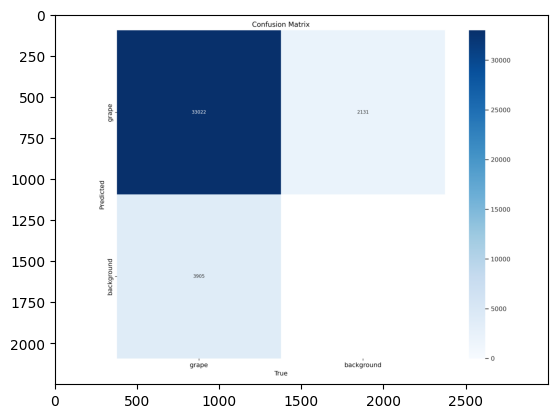

In [11]:
confusion_matrix = Image.open('runs/detect/val17/confusion_matrix.png')
plt.imshow(confusion_matrix)

## Contagem de Cachos e Uvas

### Contagem de Cachos

In [ ]:
video_frames_dir = Path('wgisd/extra/video_demo_frames')
model_path = Path('cluster_detection/v8n2/weights/best.pt')
temp_imgs_dir = Path('temp_images')
video_demo_path = Path('video_demo.mp4')

temp_imgs_dir.mkdir(exist_ok=True)

In [ ]:
cluster_detection_model = YOLO(model_path)

In [ ]:
def framesToMP4(video_frames_dir, dst_video_path, fps=12, size=(1920, 1080)):
    video_codec = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(dst_video_path, video_codec, fps, size)
    
    video_frames = sorted(video_frames_dir.iterdir())
    
    for frame_path in video_frames:
        frame = cv2.imread(str(frame_path))
        video_writer.write(frame)
    video_writer.release()

framesToMP4(video_frames_dir, video_demo_path)

Para cada frame o modelo de detecção de cachos é rodado e os cachos são destacados e contados. Os cachos são contados e destacado somente na primeira vez que aparecem em um frame.

In [ ]:
cap = cv2.VideoCapture(video_demo_path)
clusters_ids = set()

while cap.isOpened():
    success, frame = cap.read()
    
    if success:
        results = cluster_detection_model.track(frame, persist=True)
        ids = results[0].boxes.id.cpu().tolist()
        boxes = results[0].boxes.xyxy.cpu().tolist()
        clusters_ids.update(ids)

        new_boxes_indexes = [ids.index(x) for x in ids if x not in clusters_ids]
        new_boxes = [boxes[i] for i in new_boxes_indexes]

        for i, box in enumerate(new_boxes):
        
            x1, x2, y1, y2 = int(box[0]), int(box[2]), int(box[1]), int(box[3])
            cropped_image = img[y1:y2, x1:x2]
    
            _cropped_image = Image.fromarray(cropped_image, 'RGB')
            _cropped_image.save(temp_imgs_dir/f'{uuid.uuid4().hex}.jpg')
    else:
        break
cap.release()

In [ ]:
print(f'Número de Clusters: {len(clusters_ids)}')

### Contagem de uvas

Modelo de detecção de uvas é utilizado nos cachos destacados pelo modelo de detecção de cachos.

In [ ]:
model_path = Path('grapes_detection/v8n2/weights/best.pt')

In [ ]:
grapes_detection_model = YOLO(model_path)

In [ ]:
num_grapes = 0

for img in temp_imgs_dir:
    results = grapes_detection_model.predict(img)
    boxes = results[0].boxes.xyxy.cpu().tolist()

    num_grapes += len(boxes)

In [ ]:
print(f'Número de Uvas: {num_grapes}')

In [ ]:
cluster_detection_model = YOLO('cluster_detection/v8n2/weights/best.pt')
grapes_detection_model = YOLO('grapes_detection/v8n2/weights/best.pt')
temp_imgs_dir = Path('temp_images')
temp_imgs_dir.mkdir(exist_ok=True)

def yield_estimation(video_path):

    cap = cv2.VideoCapture(video_path)
    clusters_ids = set()
    
    while cap.isOpened():
        success, frame = cap.read()
        
        if success:
            results = cluster_detection_model.track(frame, persist=True)
            ids = results[0].boxes.id.cpu().tolist()
            boxes = results[0].boxes.xyxy.cpu().tolist()
            clusters_ids.update(ids)
    
            new_boxes_indexes = [ids.index(x) for x in ids if x not in clusters_ids]
            new_boxes = [boxes[i] for i in new_boxes_indexes]
    
            for i, box in enumerate(new_boxes):
            
                x1, x2, y1, y2 = int(box[0]), int(box[2]), int(box[1]), int(box[3])
                cropped_image = img[y1:y2, x1:x2]
        
                _cropped_image = Image.fromarray(cropped_image, 'RGB')
                _cropped_image.save(temp_imgs_dir/f'{uuid.uuid4().hex}.jpg')
        else:
            break
    cap.release()

    num_grapes = 0

    for img in temp_imgs_dir:
        results = grapes_detection_model.predict(img)
        boxes = results[0].boxes.xyxy.cpu().tolist()
    
        num_grapes += len(boxes)

    return len(clusters_ids), num_grapes
    